In [1]:
## Reload the modules each time there are modified
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML
from src.utils import print_loading

from src.arms import Bernoulli
from src.stochastic_bandit import MAB, BernoulliMAB
from src.multiplayers import MultiplayerEnv, PlayerRandTop, PlayerMCTop, UCB1Policy, KlUCBPolicy, PlayerSelfish, multiple_runs

In [3]:
BernoulliMAB([0.5, 0.2, 0.8, 0.6, 0.3, 0.35, 0.7]).m_worst_arms_means(3)

array([0.5 , 0.35, 0.3 , 0.2 ])

In [4]:
bandit = BernoulliMAB([0.2, 0.3, 0.5, 0.75, 0.8])
K, M = bandit.nb_arms, 3
policy = UCB1Policy(alpha=0.5)
players = [PlayerSelfish(K, M, policy) for _ in range(M)]

In [7]:
time_horizon = 2000
env = MultiplayerEnv(bandit, players, time_horizon)

In [8]:
cum_regret, end_regrets = multiple_runs(env, N_exp=20)

20/20 [====================] (100%)

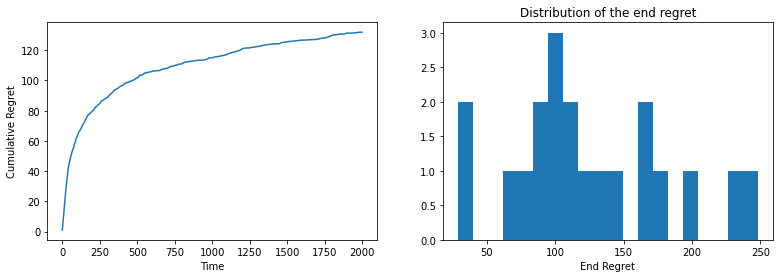

In [9]:
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.plot(cum_regret)
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")

plt.subplot(122)
plt.hist(end_regrets, bins=20)
plt.title("Distribution of the end regret")
plt.xlabel("End Regret")
plt.show()

In [5]:
bandit = BernoulliMAB([p / 10 for p in range(1, 10)])
K, M = bandit.nb_arms, 3

mctop_klucb = [PlayerMCTop(K, M, KlUCBPolicy([Bernoulli for _ in range(K)])) for _ in range(M)]
randtop_klucb = [PlayerRandTop(K, M, KlUCBPolicy([Bernoulli for _ in range(K)])) for _ in range(M)]
mctop_ucb1 = [PlayerMCTop(K, M, UCB1Policy(0.5)) for _ in range(M)]
randtop_ucb1 = [PlayerRandTop(K, M, UCB1Policy(0.5)) for _ in range(M)]
selfish_ucb1 = [PlayerSelfish(K, M, UCB1Policy(0.5)) for _ in range(M)]
# strategies = {"RandTopM-klUCB": randtop_klucb, "RandTopM-UCB1": randtop_ucb1, "MCTopM-klUCB": mctop_klucb, "MCTopM-UCB1": mctop_ucb1}
strategies = {"RandTopM-UCB1": randtop_ucb1, "MCTopM-UCB1": mctop_ucb1, "Selfish-UCB1": selfish_ucb1}

In [6]:
time_horizon, N_runs = 2000, 100
cum_regrets = {strategy: None for strategy in strategies}
for name, players in strategies.items():
    print(name)
    cum_regret, end_regret = multiple_runs(MultiplayerEnv(bandit, players, time_horizon), N_runs)
    cum_regrets[name] = cum_regret
    print()

RandTopM-UCB1
100/100 [====================] (100%)
MCTopM-UCB1
100/100 [====================] (100%)
Selfish-UCB1
100/100 [====================] (100%)


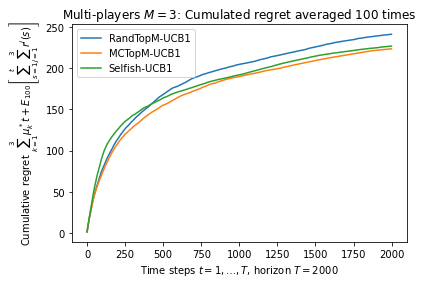

In [7]:
for name, cum_regret in cum_regrets.items():
    plt.plot(cum_regret, label=name)

plt.xlabel(fr"Time steps $t=1, \dots, T$, horizon $T={time_horizon}$")
plt.ylabel(fr"Cumulative regret $\sum_{{k=1}}^{{{M}}} \mu_k^* t + E_{{{N_runs}}}\left[\sum_{{s=1}}^t\sum_{{j=1}}^{M}r^j(s)\right]$")
plt.title(fr"Multi-players $M={M}$: Cumulated regret averaged {N_runs} times")
plt.legend()
plt.show()

------

In [10]:
players = [PlayerRandTop(K, M, UCB1Policy(0.5)) for _ in range(M)]
env = MultiplayerEnv(bandit, players, time_horizon=200)
env.run()

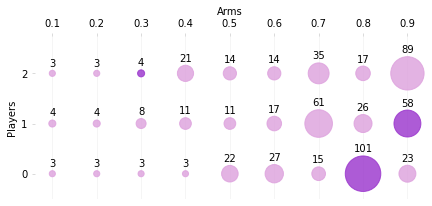

In [11]:
MAX_SIZE = 2500
fig = plt.figure(figsize=(7, env.M))

colors = ["plum"] * env.K
for j in range(M):
    arms_selected, nb_draws = np.unique(env.selections[j], return_counts=True)
    sizes = MAX_SIZE * nb_draws / env.time_horizon

    sc = plt.scatter(arms_selected, 0*arms_selected + j, s=sizes, color=["plum" if env.selections[j, -1] != k else "firebrick" if env.collisions[j, -1] else "darkorchid" for k in range(env.K)], alpha=.8)
    for k, n, s in zip(arms_selected, nb_draws, sizes):
        plt.annotate(n, xy=(k, j), xytext=(0, np.sqrt(s)/2+2), textcoords="offset points", ha='center', va='bottom', zorder=11)
    # plt.scatter(env.selections[j, -1], j, s=100, color='red',edgecolors="darkorange", lw=1.5, marker='X')
for k in range(env.K):
    plt.axvline(k, c="whitesmoke", lw=1, zorder=0)
# plt.axis("off")
plt.ylim(-0.5, M-.25)
plt.xticks(range(env.K), env.bandit.means)
plt.yticks(range(env.M))
plt.xlabel("Arms")
plt.ylabel("Players")
plt.gca().xaxis.set_label_position('top')
# plt.axis("off")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tick_params(color="lightgrey", labelbottom=False, labeltop=True, top=True, bottom=False)

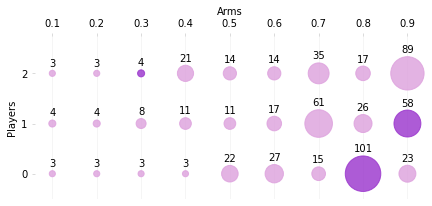

In [14]:
HTML(env.animation().to_jshtml())